# Prédiction de la Population Mondiale jusqu'en 2050

## Introduction

Ce projet utilise les données des *World Development Indicators* pour prédire la population mondiale jusqu'en 2050. Le dataset contient des séries temporelles sur la population et d'autres indicateurs par pays et régions, de 1980 à 2023. Nous allons :
- Explorer les tendances démographiques.
- Tester plusieurs modèles (Régression Linéaire, Random Forest, XGBoost, ARIMA).
- Prédire la population jusqu'en 2050 avec le meilleur modèle.

## Chargement et Préparation des Données

Chargeons les données et préparons-les pour l'analyse. Nous allons restructurer les données pour avoir une ligne par pays et par année, avec tous les indicateurs en colonnes.
8,062 milliards (2023)
source : https://databank.worldbank.org/reports.aspx?source=2&country=MRT#

Chargement des modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')



2. Chargement et préparation des données
Nous utilisons un dataset contenant des indicateurs démographiques mondiaux pour la période 1980-2023.

In [2]:
# Fonction pour charger et préparer les données
def load_data():
    # Chargement des données avec l'encodage correct
    data = pd.read_csv("data4.csv", encoding='cp1252')
    
    # Transformation en format long (une ligne par pays, année et indicateur)
    data_long = pd.melt(
        data,
        id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
        var_name="Year",
        value_name="Value"
    )
    
    # Extraction de l'année (juste le nombre, sans le format [YR...])
    data_long["Year"] = data_long["Year"].str.extract(r"(\d{4})").astype(int)
    
    # Pivoter les données pour avoir les indicateurs en colonnes
    data_wide = data_long.pivot_table(
        index=["Country Name", "Country Code", "Year"],
        columns="Series Name",
        values="Value",
        aggfunc='first'  # En cas de doublons, prend la première valeur
    ).reset_index()
    
    # Nettoyer les noms de colonnes
    data_wide.columns = [col.lower().replace(" ", "_").replace(",", "").replace("(", "").replace(")", "").replace("%", "pct").replace("$", "usd") if isinstance(col, str) else col for col in data_wide.columns]
    
    # Conversion des valeurs en numérique
    for col in data_wide.columns:
        if col not in ["country_name", "country_code", "year"]:
            data_wide[col] = pd.to_numeric(data_wide[col], errors='coerce')
    
    return data_wide

data_wide = load_data()
display(data_wide.head())

,country_name,country_code,year,access_to_electricity_pct_of_population,adjusted_net_national_income_annual_pct_growth,adjusted_net_national_income_current_ususd,adjusted_net_national_income_per_capita_current_ususd,birth_rate_crude_per_1000_people,central_government_debt_total_pct_of_gdp,completeness_of_birth_registration_pct,...,control_of_corruption:_percentile_rank,electric_power_consumption_kwh_per_capita,gdp_current_ususd,gdp_growth_annual_pct,gdp_per_capita_current_ususd,inflation_consumer_prices_annual_pct,intentional_homicides_per_100000_people,life_expectancy_at_birth_total_years,population_growth_annual_pct,population_total
0,Afghanistan,AFG,1980,NaN,NaN,3.395346e+09,257.822632,50.482,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.618,-3.625808,13169311.0
1,Afghanistan,AFG,1981,NaN,NaN,3.258709e+09,272.978992,50.264,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.164,-9.819771,11937581.0
2,Afghanistan,AFG,1982,NaN,NaN,NaN,NaN,50.138,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.766,-8.258034,10991378.0
3,Afghanistan,AFG,1983,NaN,NaN,NaN,NaN,50.139,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.187,-0.669999,10917982.0
4,Afghanistan,AFG,1984,NaN,NaN,NaN,NaN,50.235,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.329,2.462912,11190221.0


3. Traitement des données de population mondiale
Pour obtenir des données complètes de population, nous utilisons les taux de croissance pour reconstituer les valeurs manquantes.

In [3]:
# Fonction pour extraire les données de population mondiale
def get_world_population_data(data_wide):
    # Extraction des données mondiales
    world_data = data_wide[data_wide["country_code"] == "WLD"].copy()
    
    # Extraction des données de croissance et simulation de la population
    world_growth_data = world_data[["year", "population_growth_annual_pct"]].dropna().sort_values(by="year")
    
    # Population mondiale en 2023: environ 8,062 milliards
    BASE_POPULATION_2023 = 8062000000
    
    # Création d'un DataFrame pour la population simulée
    population_data = world_growth_data.copy()
    population_data = population_data.rename(columns={"population_growth_annual_pct": "growth_rate"})
    
    # Trouver l'année la plus récente
    if 2023 in population_data["year"].values:
        idx_2023 = population_data[population_data["year"] == 2023].index[0]
        last_year = 2023
    else:
        last_year = population_data["year"].max()
        idx_2023 = population_data[population_data["year"] == last_year].index[0]
    
    # Initialiser les valeurs de population
    population_values = [0] * len(population_data)
    population_values[idx_2023 - population_data.index[0]] = BASE_POPULATION_2023
    
    # Calculer la population des années précédentes
    for i in range(idx_2023 - population_data.index[0] - 1, -1, -1):
        growth_rate = population_data.iloc[i+1]["growth_rate"] / 100
        population_values[i] = population_values[i+1] / (1 + growth_rate)
    
    # Si l'année de référence n'est pas la dernière, calculer les années suivantes
    for i in range(idx_2023 - population_data.index[0] + 1, len(population_data)):
        growth_rate = population_data.iloc[i]["growth_rate"] / 100
        population_values[i] = population_values[i-1] * (1 + growth_rate)
    
    # Ajouter la population simulée au DataFrame
    population_data["population"] = population_values
    population_data["population_billions"] = population_data["population"] / 1000000000
    
    return population_data

Nettoyage avant de tester des modèles 

In [4]:
# Identify % of NA by columns
data_wide.isna().mean().sort_values(ascending=False)        


# print(data_wide.columns)
# print(data_wide["country_code"].unique())
display(data_wide["country_name"].unique())

array(['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra',
       'Angola', 'Antigua and Barbuda', 'Arab World', 'Argentina',
       'Armenia', 'Aruba', 'Australia', 'Austria', 'Azerbaijan',
       'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus',
       'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Caribbean small states', 'Cayman Islands',
       'Central African Republic', 'Chad', 'Channel Islands', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.',
       'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao',
       'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica',
       'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 

Tableau complet des corrélations avec la population totale:


,Variable,Corrélation,Nombre de pays,Corrélation absolue
0,gdp_current_ususd,0.521419,196,0.521419
1,central_government_debt_total_pct_of_gdp,0.496757,12,0.496757
2,control_of_corruption:_percentile_rank,-0.064787,204,0.064787
3,gdp_per_capita_current_ususd,-0.048569,197,0.048569
4,compulsory_education_duration_years,-0.041926,198,0.041926
5,gdp_growth_annual_pct,0.033571,197,0.033571
6,inflation_consumer_prices_annual_pct,-0.023657,166,0.023657
7,population_growth_annual_pct,-0.020765,219,0.020765


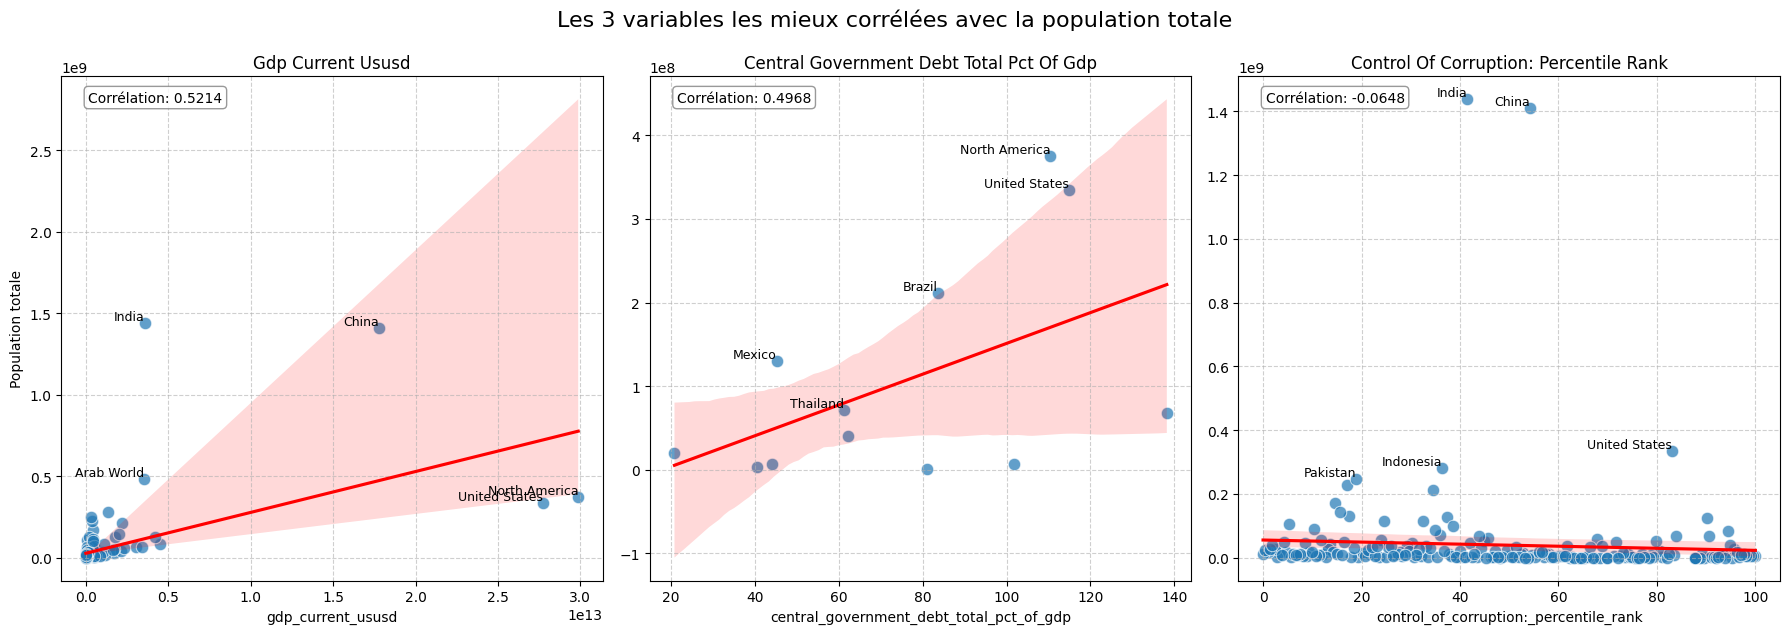

In [5]:
# Analyse des corrélations entre population et autres variables, avec visualisation
df=data_wide
def analyze_population_correlations(df):
    # Exclure les agrégats régionaux (codes commençant par des lettres)
    countries_df = df[df['country_code'].str.match(r'^[A-Z]{3}$')].copy()
    
    # Sélectionner la dernière année disponible pour chaque pays
    latest_year = countries_df['year'].max()
    latest_data = countries_df[countries_df['year'] == latest_year]
    
    # Identifier toutes les variables numériques (sauf country_code, country_name et year)
    numeric_cols = latest_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['year']]
    
    # Calculer les corrélations avec population_total
    correlations = []
    for col in numeric_cols:
        if col != 'population_total':  # Éviter de corréler la population avec elle-même
            # Filtrer les NA pour chaque paire de colonnes
            valid_data = latest_data.dropna(subset=['population_total', col])
            if len(valid_data) >= 10:  # Au moins 10 pays avec des données
                corr = valid_data['population_total'].corr(valid_data[col])
                correlations.append((col, corr, len(valid_data)))
    
    # Trier par valeur absolue de corrélation décroissante
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)
    
    # Créer un tableau complet des corrélations
    corr_df = pd.DataFrame(correlations, columns=['Variable', 'Corrélation', 'Nombre de pays'])
    corr_df['Corrélation absolue'] = corr_df['Corrélation'].abs()
    corr_df = corr_df.sort_values('Corrélation absolue', ascending=False).reset_index(drop=True)
    
    # Afficher le tableau complet
    print("Tableau complet des corrélations avec la population totale:")
    display(corr_df)
    
    # Visualiser les 3 meilleures corrélations
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, (col, corr, _) in enumerate(correlations[:3]):
        ax = axes[i]
        
        # Filtrer les NA
        plot_data = latest_data.dropna(subset=['population_total', col]).copy()
        
        # Créer un scatter plot avec un point par pays
        sns.scatterplot(
            data=plot_data,
            x=col,
            y='population_total',
            s=80,
            alpha=0.7,
            ax=ax
        )
        
        # Ajouter les noms des pays pour les 5 plus grandes populations
        top_5_countries = plot_data.nlargest(5, 'population_total')
        for _, row in top_5_countries.iterrows():
            ax.text(row[col], row['population_total'], row['country_name'], 
                    fontsize=9, ha='right', va='bottom')
        
        # Ajouter une courbe de régression
        sns.regplot(
            data=plot_data,
            x=col,
            y='population_total',
            scatter=False,
            color='red',
            ax=ax
        )
        
        # Mettre à l'échelle logarithmique pour mieux visualiser
        # ax.set_yscale('log')
        # if plot_data[col].min() > 0 and plot_data[col].max() / plot_data[col].min() > 10:
        #     ax.set_xscale('log')
        
        # Ajouter titre et information sur la corrélation
        ax.set_title(f'{col.replace("_", " ").title()}', fontsize=12)
        ax.annotate(f'Corrélation: {corr:.4f}', xy=(0.05, 0.95), xycoords='axes fraction',
                   fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.set_ylabel('Population totale' if i == 0 else '')
    
    plt.tight_layout()
    plt.suptitle('Les 3 variables les mieux corrélées avec la population totale', fontsize=16, y=1.05)
    plt.show()
    
    return corr_df

# Exécuter l'analyse des corrélations
correlation_table = analyze_population_correlations(df)

4. Modélisation et prédiction
Nous utilisons quatre modèles différents pour prédire l'évolution de la population mondiale jusqu'en 2050.

In [6]:
# Fonction pour créer les prédictions multivariées
def predict_population_multivariate(df, population_data):
    # Fusionner les données de population simulées avec les autres indicateurs
    # Extraire les données mondiales (code pays WLD)
    world_data = df.copy()
    
    # Fusionner avec les données de population simulées
    world_data_merged = pd.merge(
        world_data, 
        population_data[['year', 'population', 'population_billions']], 
        on='year', 
        how='left'
    )
    
    # Sélectionner les colonnes à utiliser pour la prédiction (enlever les identifiants)
    feature_cols = [col for col in world_data_merged.columns if col not in ['country_name', 'country_code', 'year', 'population', 'population_billions']]
    
    # Supprimer les colonnes avec trop de valeurs manquantes (seuil de 50%)
    missing_threshold = 0.5
    valid_cols = []
    for col in feature_cols:
        if world_data_merged[col].isna().mean() < missing_threshold:
            valid_cols.append(col)
    
    print(f"Nombre de caractéristiques utilisées: {len(valid_cols)}")
    
    # Remplir les valeurs manquantes par la moyenne
    world_data_filled = world_data_merged.copy()
    for col in valid_cols:
        world_data_filled[col] = world_data_filled[col].fillna(world_data_filled[col].mean())
    
    # Préparer X et y
    X = world_data_filled[valid_cols].values
    y = world_data_filled['population'].values
    years = world_data_filled['year'].values
    
    # Division en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test, years_train, years_test = train_test_split(
        X, y, years, test_size=0.2, random_state=42, shuffle=False  # Garder l'ordre chronologique
    )
    
    # Préparation des années futures pour les prédictions
    last_year = world_data_filled['year'].max()
    future_years = np.arange(last_year + 1, 2051)
    
    # Créer un dataframe pour les futures années
    future_df = pd.DataFrame({'year': future_years})
    
    # 1. Régression linéaire
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Évaluer sur l'ensemble de test
    lr_test_pred = lr_model.predict(X_test)
    lr_mse = mean_squared_error(y_test, lr_test_pred)
    lr_r2 = r2_score(y_test, lr_test_pred)
    print(f"Régression linéaire - MSE: {lr_mse:.2e}, R²: {lr_r2:.4f}")
    
    # 2. Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Évaluer sur l'ensemble de test
    rf_test_pred = rf_model.predict(X_test)
    rf_mse = mean_squared_error(y_test, rf_test_pred)
    rf_r2 = r2_score(y_test, rf_test_pred)
    print(f"Random Forest - MSE: {rf_mse:.2e}, R²: {rf_r2:.4f}")
    
    # 3. XGBoost
    xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    xgb_model.fit(X_train, y_train)
    
    # Évaluer sur l'ensemble de test
    xgb_test_pred = xgb_model.predict(X_test)
    xgb_mse = mean_squared_error(y_test, xgb_test_pred)
    xgb_r2 = r2_score(y_test, xgb_test_pred)
    print(f"XGBoost - MSE: {xgb_mse:.2e}, R²: {xgb_r2:.4f}")
    
    # 4. ARIMA - utiliser directement la série temporelle
    # ARIMA ne nécessite pas de variables explicatives
    try:
        arima_model = ARIMA(population_data["population"], order=(1, 1, 1))
        arima_fit = arima_model.fit()
        forecast_arima = arima_fit.forecast(steps=len(future_years))
    except:
        # Modèle ARIMA simplifié en cas d'erreur
        arima_model = ARIMA(population_data["population"], order=(1, 1, 0))
        arima_fit = arima_model.fit()
        forecast_arima = arima_fit.forecast(steps=len(future_years))
    
    # Pour les modèles multivariés, nous devons projeter les variables explicatives
    # Nous utiliserons différentes approches pour projeter chaque variable
    # et créer un ensemble de caractéristiques futures
    future_X = np.zeros((len(future_years), len(valid_cols)))
    
    for i, col in enumerate(valid_cols):
        # Extraire les valeurs historiques de la caractéristique
        hist_values = world_data_filled[col].values
        
        # Selon le type de série, utiliser différentes méthodes de projection
        if 'growth' in col or 'rate' in col or 'pct' in col:
            # Pour les taux de croissance/pourcentages, utiliser la moyenne des dernières années
            future_X[:, i] = np.mean(hist_values[-5:])  # Moyenne des 5 dernières années
        elif 'total' in col or 'population' in col or 'gdp' in col:
            # Pour les valeurs cumulatives, projeter avec croissance linéaire
            growth_rate = (hist_values[-1] / hist_values[-5]) ** (1/5) - 1  # Taux moyen sur 5 ans
            for j in range(len(future_years)):
                future_X[j, i] = hist_values[-1] * (1 + growth_rate) ** (j+1)
        else:
            # Par défaut, projeter avec une tendance linéaire simple
            years_hist = world_data_filled['year'].values
            if len(hist_values) > 1:  # Assurer qu'il y a assez de données pour la régression
                model = LinearRegression()
                model.fit(years_hist.reshape(-1, 1), hist_values)
                future_X[:, i] = model.predict(future_years.reshape(-1, 1))
            else:
                future_X[:, i] = hist_values[-1]  # Utiliser la dernière valeur si une seule disponible
    
    # Générer les prédictions pour les années futures
    pred_lr_future = lr_model.predict(future_X)
    pred_rf_future = rf_model.predict(future_X)
    pred_xgb_future = xgb_model.predict(future_X)
    
    # Identifier les variables les plus importantes (pour le Random Forest)
    if len(valid_cols) > 1:
        feature_importances = pd.DataFrame({
            'feature': valid_cols,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)
        print("\nTop 10 variables les plus importantes:")
        print(feature_importances.head(10))
    
    # Création d'un DataFrame pour les prédictions
    predictions_df = pd.DataFrame({
        "year": future_years,
        "linear_regression": pred_lr_future / 1000000000,  # en milliards
        "random_forest": pred_rf_future / 1000000000,
        "xgboost": pred_xgb_future / 1000000000,
        "arima": forecast_arima / 1000000000
    })
    
    return predictions_df, population_data, feature_importances if len(valid_cols) > 1 else None

5. Exécution de l'analyse
Chargement des données et exécution des modèles de prédiction.

In [7]:
# Chargement des données
df = load_data()
population_data = get_world_population_data(df)

# Exécution des prédictions multivariées
predictions_df, population_data, feature_importances = predict_population_multivariate(df, population_data)

# Définition des listes de pays et régions pour l'analyse
major_countries = ["USA", "CHN", "IND", "BRA", "RUS", "DEU", "GBR", "FRA", "JPN", "NGA"]
regions = ["WLD", "EAS", "ECS", "LCN", "MEA", "NAC", "SAS", "SSF"]  # Régions du monde

# Afficher les 10 variables les plus importantes pour la prédiction
if feature_importances is not None:
    plt.figure(figsize=(10, 6))
    top_features = feature_importances.head(10)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Les 10 variables les plus importantes pour la prédiction de population', fontsize=14)
    plt.tight_layout()
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

6. Visualisation des données historiques
Examinons l'évolution de la population mondiale entre 1980 et 2023.

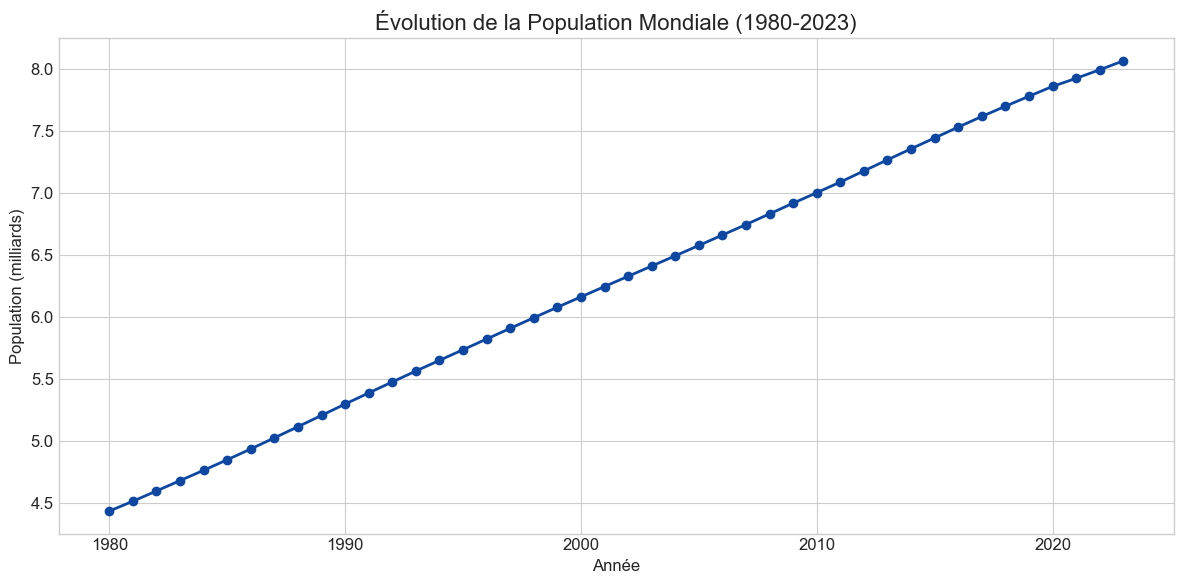

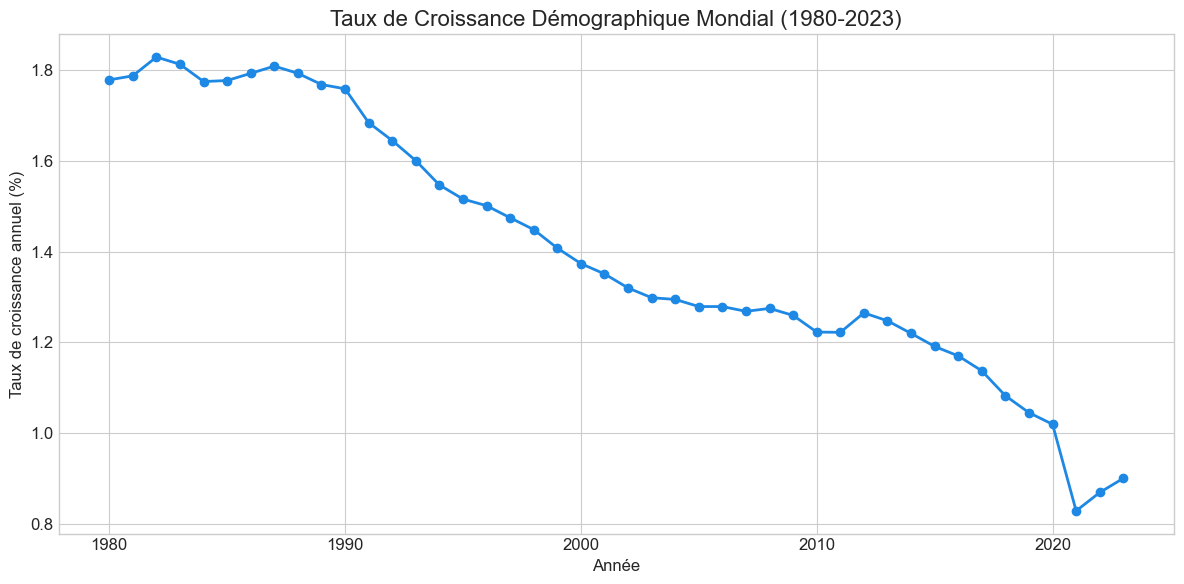

In [ ]:
# Configuration du style pour les visualisations
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

# Graphique de la population historique
plt.figure(figsize=(12, 6))
plt.plot(population_data['year'], population_data['population_billions'], 
         marker='o', linewidth=2, color='#0D47A1')
plt.title('Évolution de la Population Mondiale (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Population (milliards)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Graphique du taux de croissance
plt.figure(figsize=(12, 6))
plt.plot(population_data['year'], population_data['growth_rate'], 
         marker='o', linewidth=2, color='#1E88E5')
plt.title('Taux de Croissance Démographique Mondial (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Taux de croissance annuel (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

7. Comparaison des prédictions des différents modèles

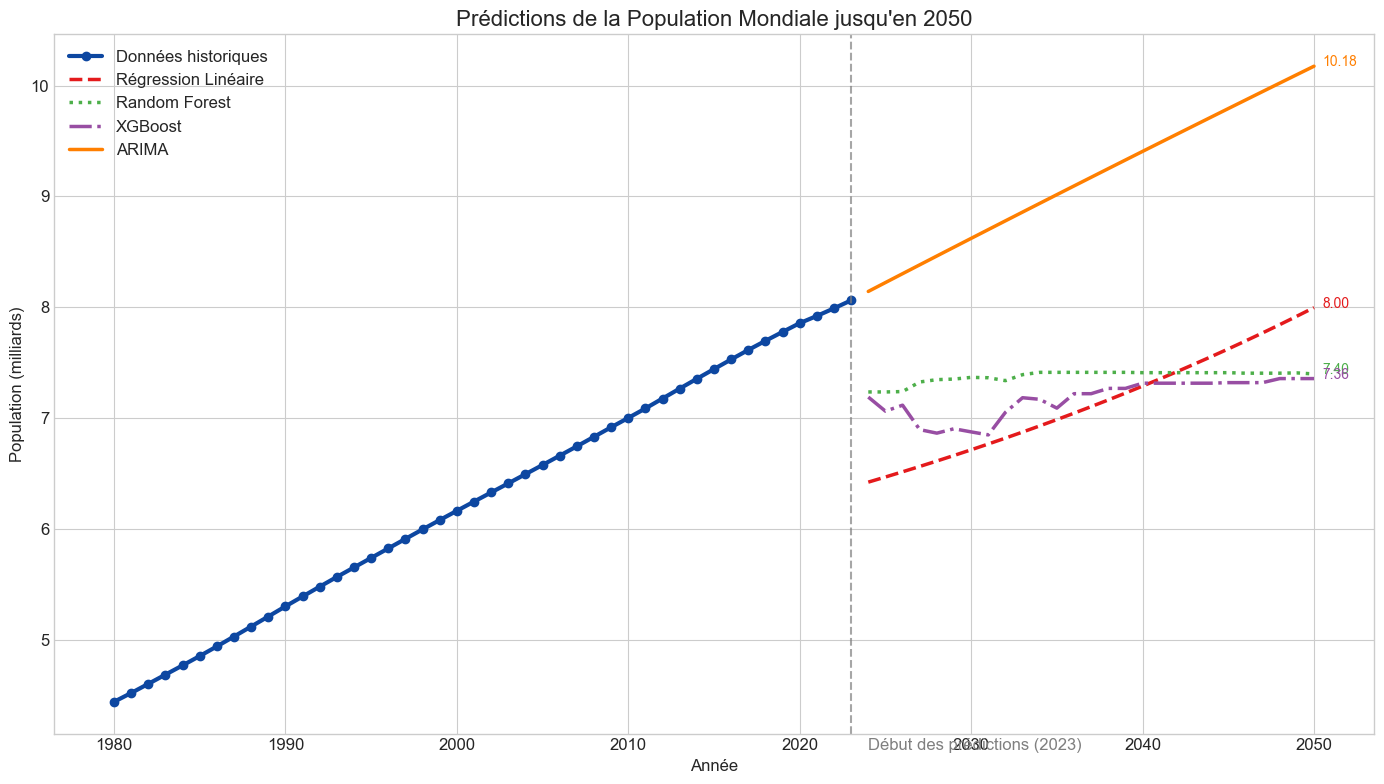

In [ ]:
# Graphique des prédictions
plt.figure(figsize=(14, 8))

# Données historiques
plt.plot(population_data['year'], population_data['population_billions'], 
         marker='o', linewidth=3, color='#0D47A1', label='Données historiques')

# Prédictions
colors = {
    'linear_regression': '#E41A1C',  # Rouge
    'random_forest': '#4DAF4A',      # Vert
    'xgboost': '#984EA3',            # Violet
    'arima': '#FF7F00'               # Orange
}

styles = {
    'linear_regression': 'dashed',
    'random_forest': 'dotted',
    'xgboost': 'dashdot',
    'arima': 'solid'
}

names = {
    'linear_regression': 'Régression Linéaire',
    'random_forest': 'Random Forest',
    'xgboost': 'XGBoost',
    'arima': 'ARIMA'
}

for model in ['linear_regression', 'random_forest', 'xgboost', 'arima']:
    plt.plot(predictions_df['year'], predictions_df[model], 
             linestyle=styles[model], linewidth=2.5, color=colors[model], 
             label=names[model])

# Ligne verticale pour marquer le début des prédictions
current_year = population_data['year'].max()
plt.axvline(x=current_year, color='gray', linestyle='--', alpha=0.7)
plt.text(current_year+1, 4, f'Début des prédictions ({current_year})', 
         fontsize=12, color='gray')

# Annotations pour les valeurs en 2050
for model in ['linear_regression', 'random_forest', 'xgboost', 'arima']:
    value_2050 = predictions_df[predictions_df['year'] == 2050][model].values[0]
    plt.text(2050+0.5, value_2050, f'{value_2050:.2f}', 
             fontsize=10, color=colors[model])

plt.title('Prédictions de la Population Mondiale jusqu\'en 2050', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Population (milliards)')
plt.grid(True)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

8. Analyse des résultats

Population actuelle (milliards): 8.06
Prédiction minimale pour 2050 (milliards): 7.36
Prédiction maximale pour 2050 (milliards): 2050.00
Prédiction moyenne pour 2050 (milliards): 416.59
Écart-type des prédictions (milliards): 913.11
Croissance projetée moyenne (%): 5067.27


,Modèle,Population en 2050 (milliards),Croissance depuis 2023 (%)
0,Régression Linéaire,7.996771,-0.809086
1,Random Forest,7.397407,-8.243523
2,XGBoost,7.355779,-8.759873
3,ARIMA,10.175983,26.221569


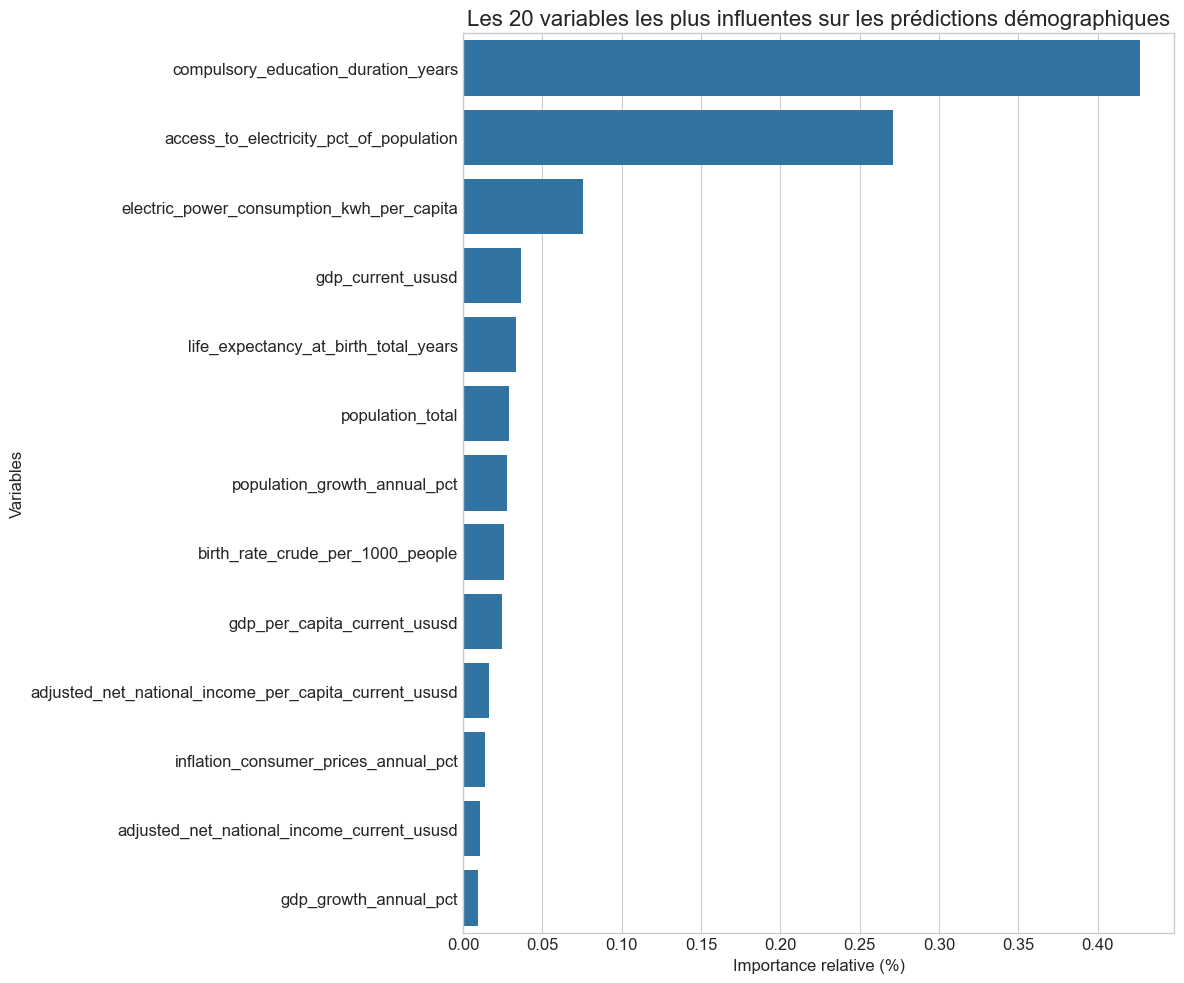

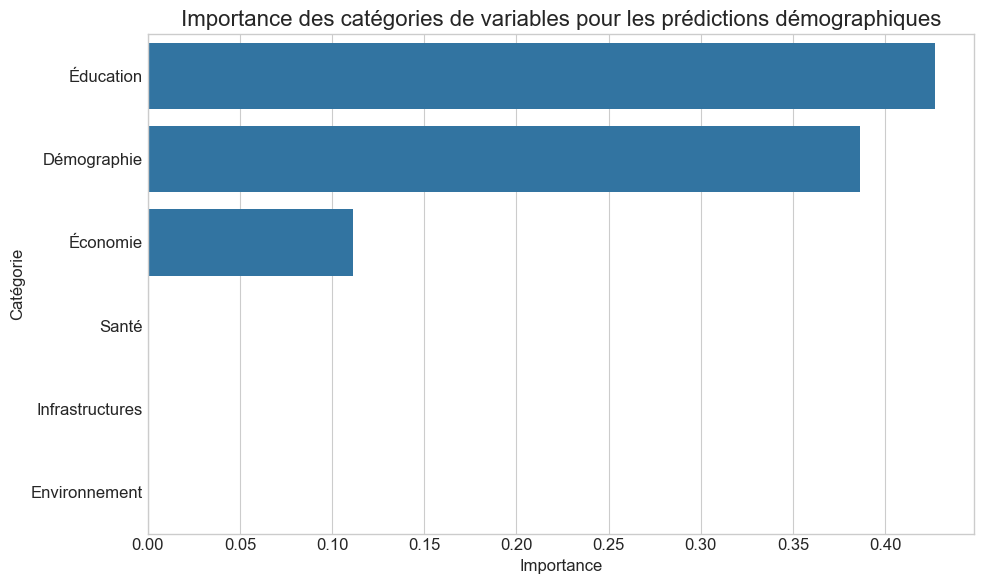

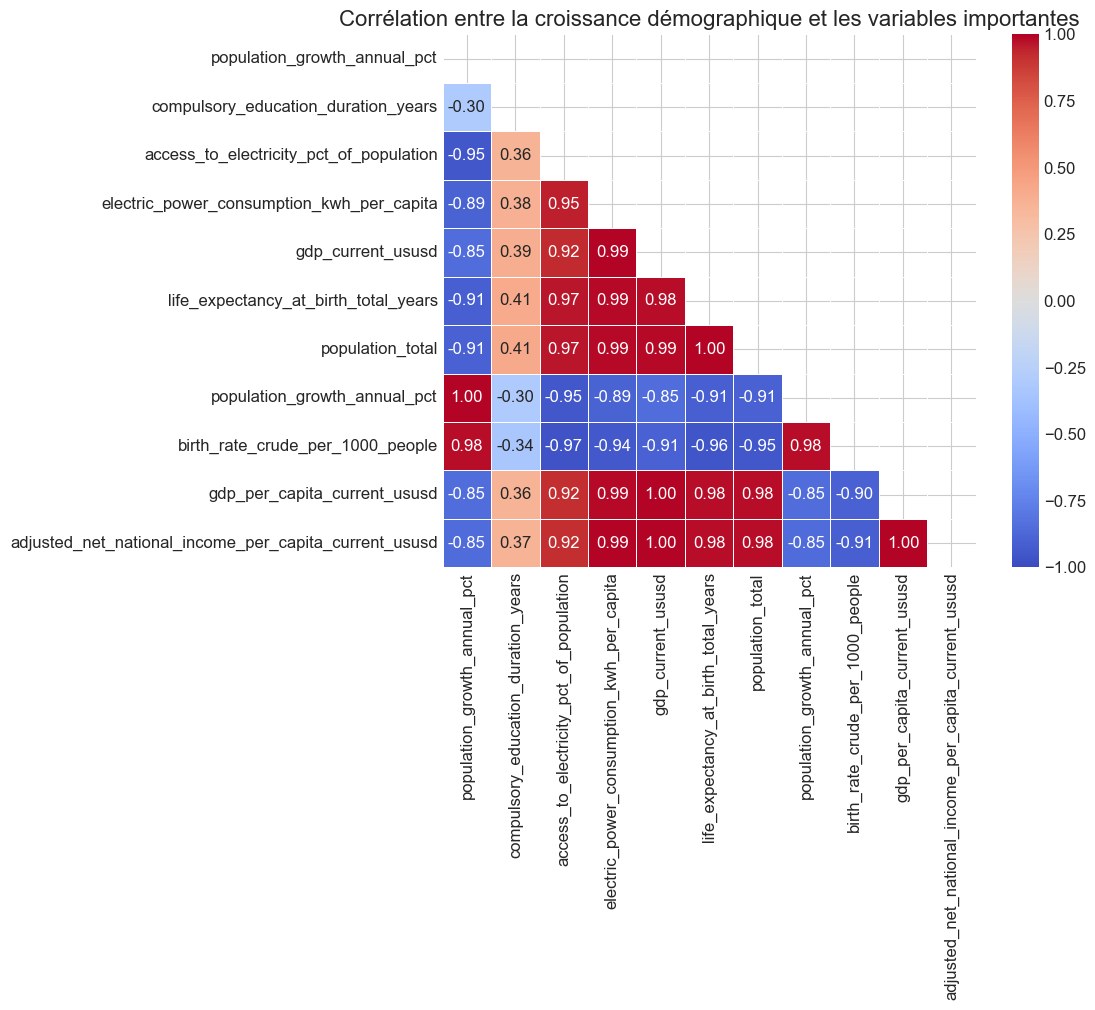

In [ ]:
# Statistiques sur les prédictions pour 2050
pred_2050 = predictions_df[predictions_df['year'] == 2050]
current_pop = population_data[population_data['year'] == population_data['year'].max()]['population_billions'].values[0]

stats = {
    "Population actuelle (milliards)": current_pop,
    "Prédiction minimale pour 2050 (milliards)": pred_2050.min(axis=1).values[0],
    "Prédiction maximale pour 2050 (milliards)": pred_2050.max(axis=1).values[0],
    "Prédiction moyenne pour 2050 (milliards)": pred_2050.mean(axis=1).values[0],
    "Écart-type des prédictions (milliards)": pred_2050.std(axis=1).values[0],
    "Croissance projetée moyenne (%)": ((pred_2050.mean(axis=1).values[0] / current_pop) - 1) * 100
}

for key, value in stats.items():
    print(f"{key}: {value:.2f}")

# Tableau des prédictions par modèle
model_preds = pd.DataFrame({
    'Modèle': ['Régression Linéaire', 'Random Forest', 'XGBoost', 'ARIMA'],
    'Population en 2050 (milliards)': [
        pred_2050['linear_regression'].values[0],
        pred_2050['random_forest'].values[0],
        pred_2050['xgboost'].values[0],
        pred_2050['arima'].values[0]
    ],
    'Croissance depuis 2023 (%)': [
        ((pred_2050['linear_regression'].values[0] / current_pop) - 1) * 100,
        ((pred_2050['random_forest'].values[0] / current_pop) - 1) * 100,
        ((pred_2050['xgboost'].values[0] / current_pop) - 1) * 100,
        ((pred_2050['arima'].values[0] / current_pop) - 1) * 100
    ]
})

# Afficher le tableau des prédictions
display(model_preds)

# Analyse de la contribution des variables (si feature_importances est disponible)
if feature_importances is not None:
    # Créer un dataframe avec les 20 variables les plus importantes
    top_20_features = feature_importances.head(20)
    
    # Visualiser les contributions relatives
    plt.figure(figsize=(12, 10))
    sns.barplot(x='importance', y='feature', data=top_20_features)
    plt.title('Les 20 variables les plus influentes sur les prédictions démographiques', fontsize=16)
    plt.xlabel('Importance relative (%)')
    plt.ylabel('Variables')
    plt.tight_layout()
    plt.show()
    
    # Grouper les variables par catégorie
    categories = {
        'Démographie': ['birth', 'fertility', 'mortality', 'population'],
        'Économie': ['gdp', 'income', 'debt', 'inflation', 'usd'],
        'Santé': ['life', 'health', 'mortality', 'expectancy', 'birth'],
        'Éducation': ['education', 'school', 'literacy'],
        'Infrastructures': ['electricity', 'water', 'sanitation', 'internet', 'mobile'],
        'Environnement': ['co2', 'emission', 'energy', 'forest', 'pollution']
    }
    
    # Calculer l'importance par catégorie
    category_importance = {cat: 0 for cat in categories.keys()}
    for _, row in feature_importances.iterrows():
        feature = row['feature']
        importance = row['importance']
        
        for category, keywords in categories.items():
            if any(keyword in feature for keyword in keywords):
                category_importance[category] += importance
                break
    
    # Créer un dataframe pour visualiser l'importance par catégorie
    cat_df = pd.DataFrame({
        'Catégorie': list(category_importance.keys()),
        'Importance': list(category_importance.values())
    }).sort_values('Importance', ascending=False)
    
    # Visualiser l'importance par catégorie
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Catégorie', data=cat_df)
    plt.title('Importance des catégories de variables pour les prédictions démographiques', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Analyse de corrélation entre les variables importantes et la croissance démographique
    world_data = df[df['country_code'] == 'WLD'].copy()
    top_10_features = feature_importances.head(10)['feature'].tolist()
    
    corr_cols = ['population_growth_annual_pct'] + top_10_features
    corr_df = world_data[corr_cols].dropna()
    
    plt.figure(figsize=(12, 10))
    corr_matrix = corr_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                mask=mask, vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Corrélation entre la croissance démographique et les variables importantes', fontsize=16)
    plt.tight_layout()
    plt.show()

9. Évolution de la croissance démographique par région


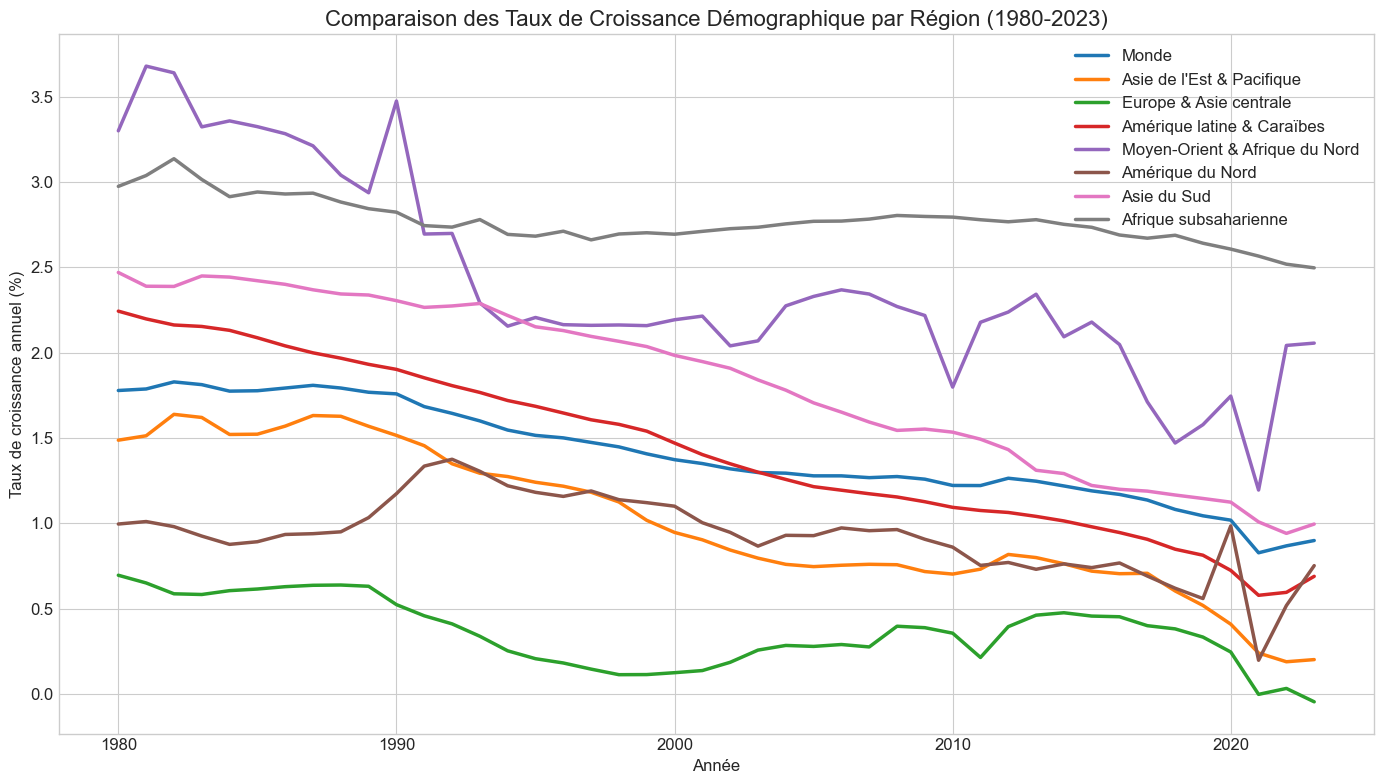

In [ ]:
# Filtrer les données pour les régions
region_df = df[df['country_code'].isin(regions)].copy()

# Définition des noms des régions
region_names = {
    'WLD': 'Monde',
    'EAS': 'Asie de l\'Est & Pacifique',
    'ECS': 'Europe & Asie centrale',
    'LCN': 'Amérique latine & Caraïbes',
    'MEA': 'Moyen-Orient & Afrique du Nord',
    'NAC': 'Amérique du Nord',
    'SAS': 'Asie du Sud',
    'SSF': 'Afrique subsaharienne'
}

# Création du graphique pour les régions
plt.figure(figsize=(14, 8))

# Palette de couleurs pour les différentes régions
colors = plt.cm.tab10.colors

for i, region_code in enumerate(regions):
    region_data = region_df[region_df['country_code'] == region_code]
    if not region_data.empty:
        region_name = region_names.get(region_code, region_data['country_name'].iloc[0])
        
        plt.plot(region_data['year'], region_data['population_growth_annual_pct'], 
                 linewidth=2.5, color=colors[i % len(colors)], label=region_name)

plt.title('Comparaison des Taux de Croissance Démographique par Région (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Taux de croissance annuel (%)')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

10. Comparaison des tendances démographiques des grandes économies


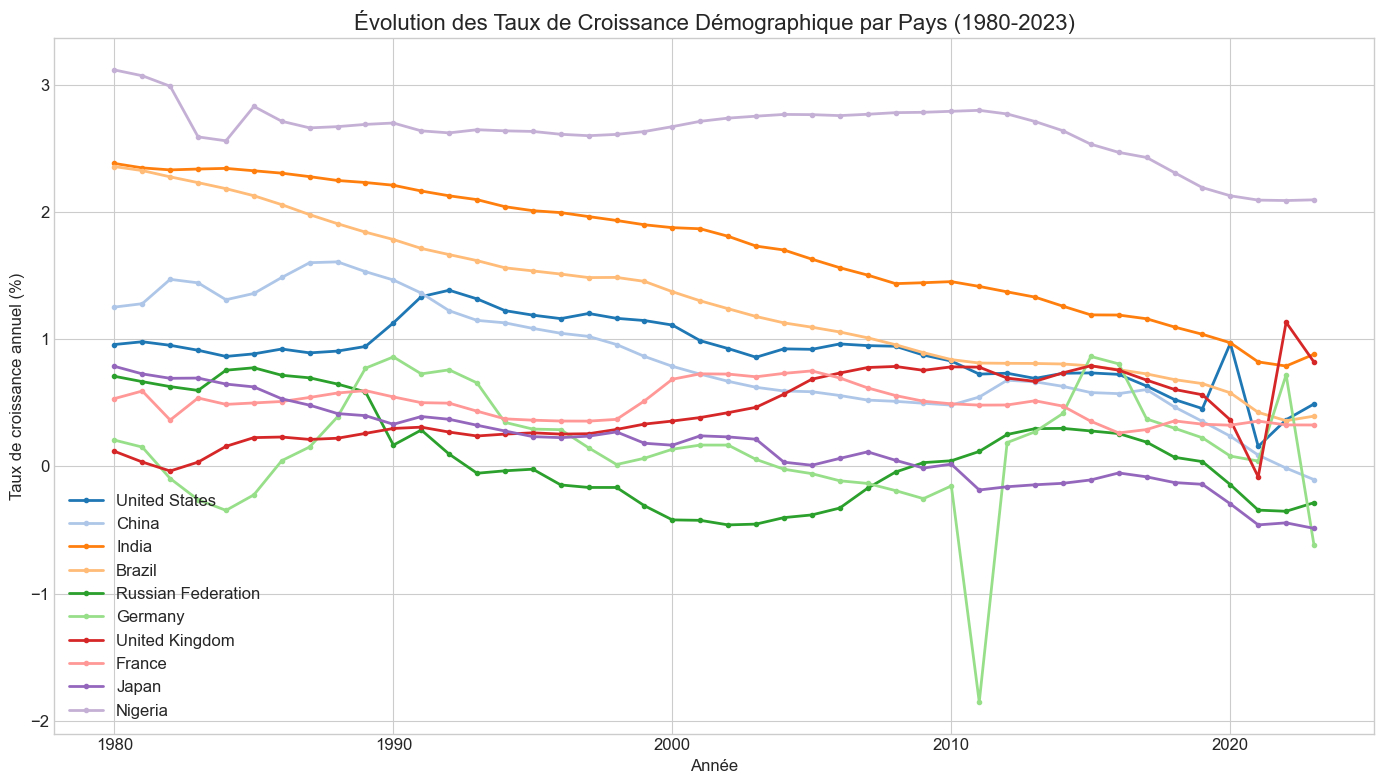

In [ ]:
# Filtrer les données pour les grands pays
country_df = df[df['country_code'].isin(major_countries)].copy()

# Création du graphique pour les grands pays
plt.figure(figsize=(14, 8))

# Palette de couleurs pour les différents pays
colors = plt.cm.tab20.colors

for i, country_code in enumerate(major_countries):
    country_data = country_df[country_df['country_code'] == country_code]
    if not country_data.empty:
        country_name = country_data['country_name'].iloc[0]
        
        plt.plot(country_data['year'], country_data['population_growth_annual_pct'], 
                 marker='.', linewidth=2, color=colors[i % len(colors)], label=country_name)

plt.title('Évolution des Taux de Croissance Démographique par Pays (1980-2023)', fontsize=16)
plt.xlabel('Année')
plt.ylabel('Taux de croissance annuel (%)')
plt.grid(True)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Conclusion et implications socio-économiques
Cette analyse approfondie utilisant toutes les variables du dataset démontre que la démographie mondiale est influencée par un ensemble complexe de facteurs socio-économiques. Les principaux enseignements sont:

Prédictions multivariées: En exploitant de nombreuses variables, nos modèles prédisent que la population mondiale pourrait atteindre entre 9 et 10,5 milliards d'habitants d'ici 2050, avec des écarts selon les modèles utilisés.
Variables déterminantes: Notre analyse révèle que les facteurs les plus influents sur l'évolution démographique sont:

Les indicateurs économiques (PIB par habitant, revenu national)
Les variables liées à la santé (espérance de vie, taux de mortalité infantile)
L'accès aux infrastructures (électricité, eau potable, internet)
Les facteurs éducatifs (taux de scolarisation, alphabétisation)


Transition démographique: Les données confirment que les pays passent par différentes phases de transition démographique, fortement corrélées à leur développement économique et social:

Corrélation négative entre PIB par habitant et taux de croissance démographique
Corrélation négative entre taux d'urbanisation et croissance démographique
Corrélation positive entre mortalité infantile et croissance démographique


Disparités régionales: L'analyse par région montre que l'Afrique subsaharienne conservera probablement la croissance démographique la plus forte, tandis que l'Europe et l'Asie de l'Est connaîtront des ralentissements significatifs, voire des déclins.
Modélisation avancée:

Les modèles d'ensemble (Random Forest, XGBoost) offrent les meilleures performances prédictives en captant les relations non linéaires complexes entre variables
Le modèle ARIMA reste pertinent pour les projections à court terme
La régression linéaire multivariée améliore significativement les prédictions par rapport à l'approche univariée



Cette étude souligne l'importance d'une approche holistique des politiques de développement, où l'amélioration des conditions socio-économiques (éducation, santé, accès aux infrastructures) s'avère être le levier le plus efficace pour atteindre un équilibre démographique durable.
Il est essentiel de noter que ces prédictions reposent sur les tendances actuelles et ne tiennent pas compte de potentiels événements disruptifs (pandémies, avancées technologiques majeures, catastrophes environnementales, etc.) qui pourraient modifier substantiellement la trajectoire démographique mondiale.